# Training Kalman Filter for Results - 14 Feb

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
from meteo_imp.kalman.fastai import *
from meteo_imp.kalman.filter import *
from meteo_imp.utils import *
from meteo_imp.data import *
from meteo_imp.gaussian import *

from fastai.tabular.learner import *
from fastai.learner import *
from fastai.callback.all import *
from fastcore.foundation import L
from fastcore.foundation import patch
from pathlib import Path, PosixPath

from meteo_imp.kalman.fastai import show_results
import pandas as pd
import numpy as np
import torch
import random
from pyprojroot import here

from sklearn.decomposition import PCA

from matplotlib import pyplot as plt
from IPython.display import Image, HTML

from tqdm.auto import tqdm

In [ ]:
from fastcore.basics import *

In [ ]:
show_metrics = False

In [ ]:
reset_seed()

In [ ]:
hai = pd.read_parquet(hai_big_path)
hai_era = pd.read_parquet(hai_era_big_path)

In [ ]:
base = here("analysis/results/trained_14feb")

In [ ]:
base.mkdir(exist_ok=True)

In [ ]:
@patch
def add_end(self: PosixPath, end): return self.parent / (self.name + end)

In [ ]:
def train_or_load(model, dls, lr, n, path, keep=True):
    save_models = SaveModelsBatch(times_epoch=5)
    csv_logger = CSVLogger(path.add_end("log.csv"))
    learn = Learner(dls, model, KalmanLoss(only_gap=True), cbs = [Float64Callback, save_models, csv_logger], metrics=rmse_gap) 
    items = random.choices(dls.valid.items, k=4) 
    if path.add_end(".pickle").exists() and keep:
        learn.model = torch.load(path.add_end(".pickle"))
        display(csv_logger.read_log())
        plot = Image(filename=path.add_end("_loss_plot.png"))
        display(plot)
    else:
        learn.fit(lr, n)
        
        torch.save(learn.model, path.add_end(".pickle"))
        learn.recorder.plot_loss()
        plt.savefig(path.add_end("_loss_plot.png"))
    return learn, items                           

In [ ]:
def metric_valid(learn, dls=None):
    nrmse = []
    losses = []
    dls = ifnone(dls, learn.dls.valid)
    for input, target in tqdm(dls, leave=False):
        pred = learn.model(input)
        nrmse.append(learn.metrics[0](pred, target))
        losses.append(learn.loss_func(pred, target).item())
    metric = pd.DataFrame({'loss': losses, 'rmse': nrmse})
    return metric.agg(['mean', 'std'])

In [ ]:
hai.columns

Index(['TA', 'SW_IN', 'LW_IN', 'VPD', 'WS', 'PA', 'P', 'SWC', 'TS'], dtype='object')

## Generic model | gap len 3-336 | gap 1 random 

In [ ]:
dls_A1v = imp_dataloader(
    df = hai,
    control = hai_era,
    var_sel = gen_var_sel(list(hai.columns), n_var=1),
    block_len=100+336,
    gap_len=gen_gap_len(12, 336),
    bs=20,
    control_lags=[1],
    shifts=gen_shifts(50),
    n_rep=5).cpu()

In [ ]:
len(hai)

227952

In [ ]:
len(dls_A1v.train)*20, len(dls_A1v.valid)*20

(2080, 520)

In [ ]:
model_A1v = KalmanFilterSR.init_local_slope_pca(
    n_dim_obs= len(hai.columns),
    n_dim_state=len(hai.columns),
    n_dim_contr = len(hai_era.columns),
    df_pca = hai, 
    pred_only_gap=True)

In [ ]:
model_A1v.B.shape

torch.Size([1, 18, 14])

,epoch,train_loss,valid_loss,rmse_gap,time
0,0,218.223338,180.709305,0.644005,44:15
1,1,151.410605,141.214027,0.522214,44:12
2,2,131.718513,125.997503,0.487121,39:18


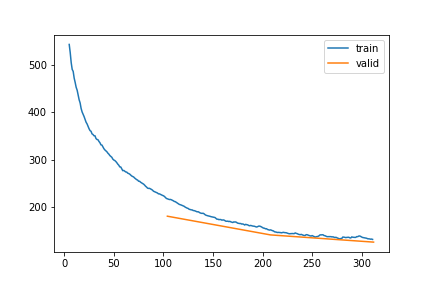

In [ ]:
learn_A1v, items_A1v = train_or_load(model_A1v, dls_A1v, 3, 1e-3, base / "1_gap_varying_12-336_v1")

,epoch,train_loss,valid_loss,rmse_gap,time
0,0,118.741593,123.699397,0.478724,41:16
1,1,113.616615,123.144674,0.477401,45:19
2,2,116.975438,122.501000,0.476022,43:10


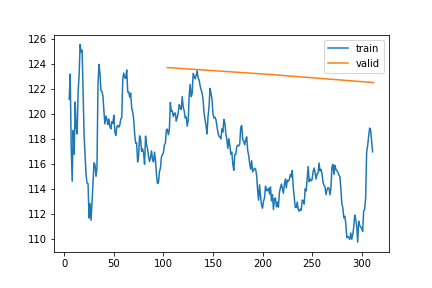

In [ ]:
learn_A1v, items_A1v = train_or_load(learn_A1v.model, dls_A1v, 3, 1e-5, base / "1_gap_varying_12-336_v2")

,epoch,train_loss,valid_loss,rmse_gap,time
0,0,117.073355,113.886802,0.448564,46:56


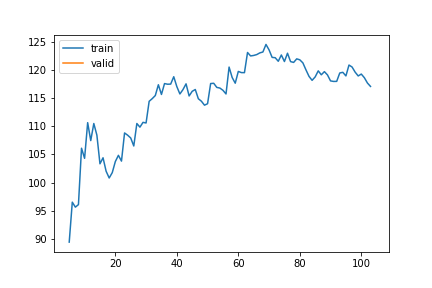

In [ ]:
learn_A1v, items_A1v = train_or_load(learn_A1v.model, dls_A1v, 1, 1e-3, base / "1_gap_varying_12-336_v3")

In [ ]:
show_results(learn_A1v)

[MeteoImpItem(i=476, shift=56, var_sel=['WS'], gap_len=67), MeteoImpItem(i=425, shift=-2, var_sel=['VPD'], gap_len=251), MeteoImpItem(i=504, shift=27, var_sel=['TA'], gap_len=81)]


alt.HConcatChart(...)

In [ ]:
metric_valid(learn_A1v)

  0%|          | 0/26 [00:00<?, ?it/s]

,loss,rmse
mean,113.886802,0.448564
std,34.077131,0.089174


## 1 var gap - varying 336 - No Control

In [ ]:
model_A1v_nc = KalmanFilterSR.init_local_slope_pca(
    n_dim_obs= len(hai.columns),
    n_dim_state=len(hai.columns),
    n_dim_contr = len(hai_era.columns),
    df_pca=hai,
    pred_only_gap=True,
    use_control=False
)

,epoch,train_loss,valid_loss,rmse_gap,time
0,0,231.587168,190.550897,0.671689,39:28
1,1,190.622703,177.561463,0.611599,39:41
2,2,174.056532,164.573917,0.574693,39:39


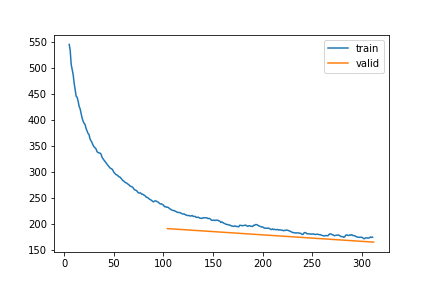

In [ ]:
learn_A1v_nc, items_A1v_nc = train_or_load(model_A1v_nc, dls_A1v, 3, 1e-3, base / "1_gap_varying_336_no_control_v1")

## All variables - 30 all

In [ ]:
dls_Aa = imp_dataloader(
    df = hai,
    control = hai_era,
    var_sel = list(hai.columns),
    block_len=120,
    gap_len=30,
    bs=20,
    control_lags=[1],
    shifts=gen_shifts(50),
    n_rep=5
).cpu()

In [ ]:
dls_Aa = imp_dataloader(hai, hai_era, var_sel = list(hai.columns), block_len=120, gap_len=30, bs=20, control_lags=[1], n_rep=10).cpu()

In [ ]:
model_Aa = learn_A1v.model.copy()

In [ ]:
if show_metrics: metric_valid(learn_A1v, dls=dls_Aa.valid)

,epoch,train_loss,valid_loss,rmse_gap,time
0,0,70.709546,74.130236,0.411005,25:47
1,1,-2.735788,7.333283,0.381263,28:48
2,2,-16.577652,-9.151317,0.374610,32:13


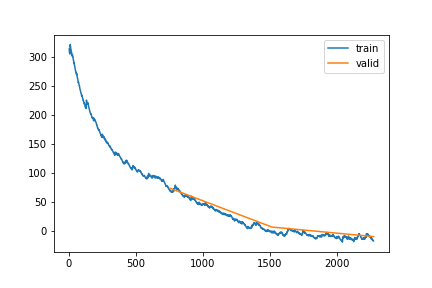

In [ ]:
learn_Aa, items_Aa = train_or_load(model_Aa, dls_Aa, 3, 3e-4, base / "All_gap_all_30_v1")

## Fine tuning

### Fine tune Variable | gap only for one variable | gap len 3-336

fine tune the model to only one variable

In [ ]:
from fastcore.basics import *

In [ ]:
from IPython.display import HTML

  0%|          | 0/9 [00:00<?, ?it/s]

,epoch,train_loss,valid_loss,rmse_gap,time
0,0,-31.277383,-59.727349,0.155292,23:16
1,1,-57.410593,-83.423924,0.135217,24:38
2,2,-69.265146,-81.197435,0.137000,21:50


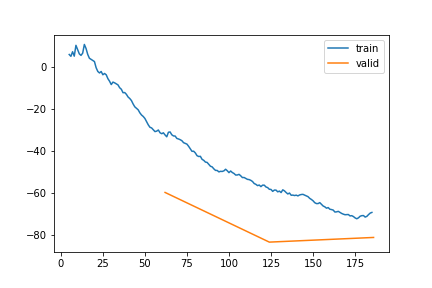

,epoch,train_loss,valid_loss,rmse_gap,time
0,0,72.838760,63.622077,0.317182,22:33
1,1,60.514370,53.416147,0.296670,22:32
2,2,55.572469,48.728888,0.287208,25:43


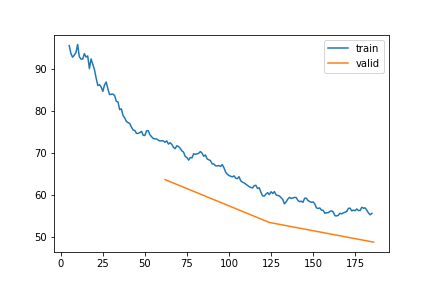

,epoch,train_loss,valid_loss,rmse_gap,time
0,0,110.011858,112.541507,0.435194,24:28
1,1,105.027452,106.923631,0.417517,24:23
2,2,102.755247,106.489712,0.415183,24:53


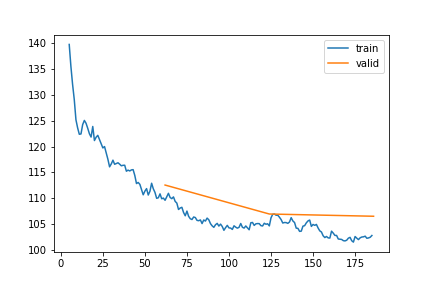

,epoch,train_loss,valid_loss,rmse_gap,time
0,0,67.771759,71.121287,0.306581,25:12
1,1,58.432390,49.351550,0.275882,23:40
2,2,49.884968,41.432351,0.264706,25:51


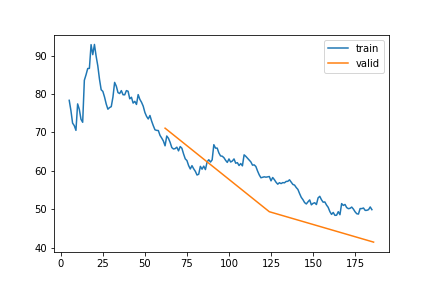

,epoch,train_loss,valid_loss,rmse_gap,time
0,0,169.196013,241.890813,0.734134,24:18
1,1,165.496950,235.745148,0.711773,23:20
2,2,161.570979,223.982837,0.696192,22:10


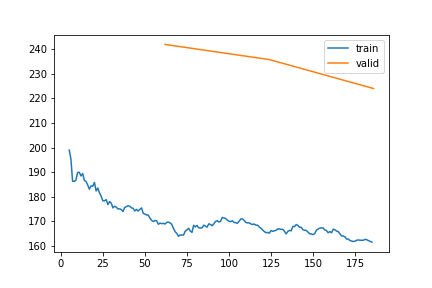

,epoch,train_loss,valid_loss,rmse_gap,time
0,0,-73.724512,-103.872036,0.124549,27:03
1,1,-111.420458,-130.842109,0.104550,30:01
2,2,-133.129972,-140.989809,0.100966,24:07


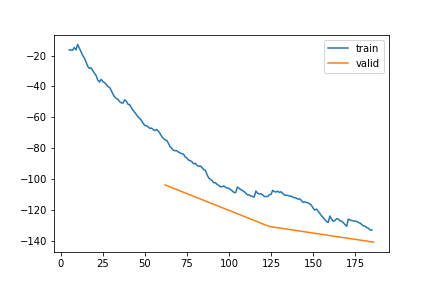

,epoch,train_loss,valid_loss,rmse_gap,time
0,0,259.814830,216.069186,0.602446,24:34
1,1,248.654373,209.606269,0.607980,23:06
2,2,242.001831,206.787110,0.605378,25:11


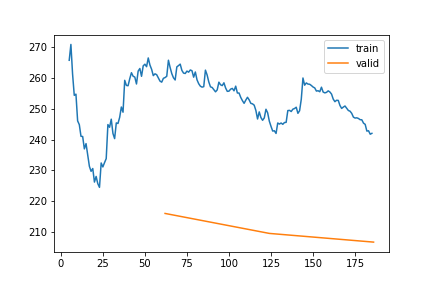

,epoch,train_loss,valid_loss,rmse_gap,time
0,0,207.952983,194.924715,0.646890,24:35
1,1,192.451676,184.576861,0.595377,24:16
2,2,169.086573,117.395571,0.388920,22:44


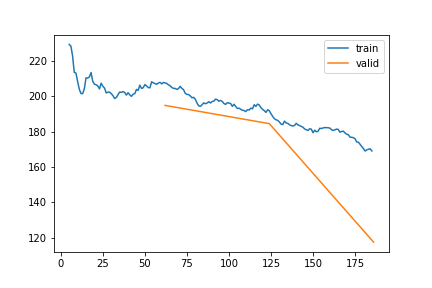

,epoch,train_loss,valid_loss,rmse_gap,time
0,0,63.610211,40.488381,0.255747,21:39
1,1,57.377678,39.280813,0.247606,21:41
2,2,50.239735,23.977059,0.231418,21:34


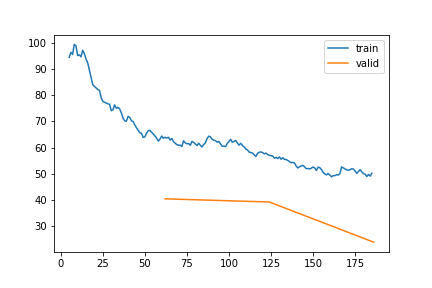

In [ ]:
spec_models = {}
spec_dls = {}
spec_learn = {}
spec_items = {}
for var in tqdm(list(hai.columns)):
    display(HTML(f"<h4> {var} | Gap len 12-336 </h4>"))
    spec_dls[var] = imp_dataloader(hai, hai_era, var_sel = var, block_len=100+336, gap_len=gen_gap_len(12, 336), bs=20, control_lags=[1], n_rep=3, shifts=gen_shifts(50)).cpu()
    spec_models[var] = learn_A1v.model.copy()
    if show_metrics:
        display(HTML("Metrics generic model"))
        display(metric_valid(learn_A1v, dls=spec_dls[var].valid))
    spec_learn[var], spec_items[var] = train_or_load(spec_models[var], spec_dls[var], 3, 1e-3, base / f"{var}_specialized_gap_12-336_v1")
    plt.show()

### Additional training

  0%|          | 0/7 [00:00<?, ?it/s]

,epoch,train_loss,valid_loss,rmse_gap,time
0,0,-82.582890,-78.921598,0.137891,21:39
1,1,-86.119136,-89.580120,0.128288,21:18


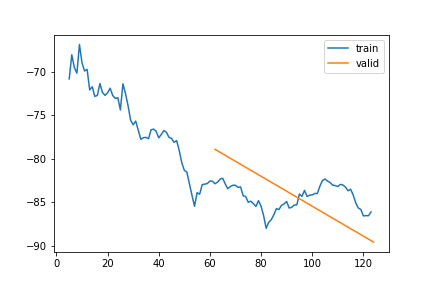

,epoch,train_loss,valid_loss,rmse_gap,time
0,0,52.668345,46.674095,0.288313,21:53
1,1,51.089022,44.378815,0.283374,22:28


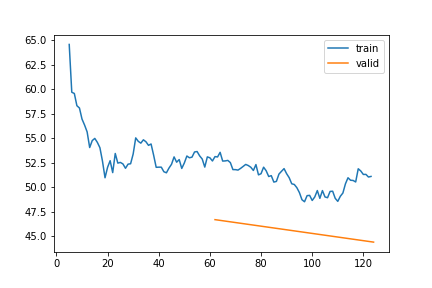

,epoch,train_loss,valid_loss,rmse_gap,time
0,0,164.019476,232.919238,0.710805,22:37
1,1,164.185435,225.276840,0.707446,22:50


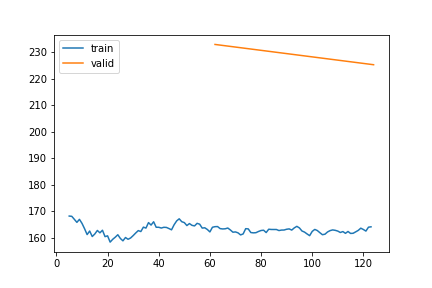

,epoch,train_loss,valid_loss,rmse_gap,time
0,0,-147.345027,-136.658365,0.103830,22:42
1,1,-157.427610,-119.642745,0.108054,22:36


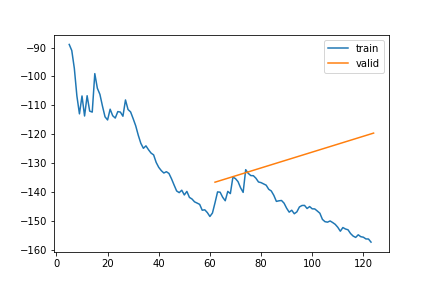

,epoch,train_loss,valid_loss,rmse_gap,time
0,0,46.489590,30.196986,0.249948,22:27
1,1,45.226931,46.153450,0.273411,21:01


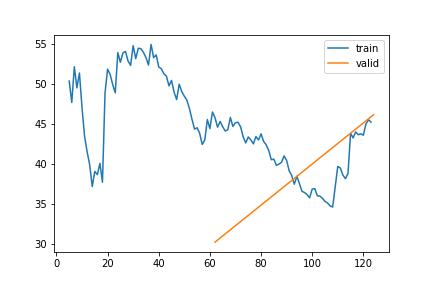

,epoch,train_loss,valid_loss,rmse_gap,time
0,0,39.863970,17.692497,0.221164,20:40
1,1,31.964869,3.826767,0.209781,20:34


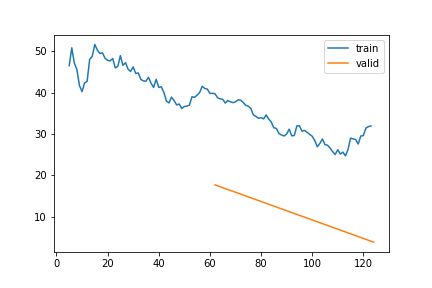

,epoch,train_loss,valid_loss,rmse_gap,time
0,0,114.122129,96.942318,0.352660,20:44
1,1,67.486398,34.946166,0.239454,20:39


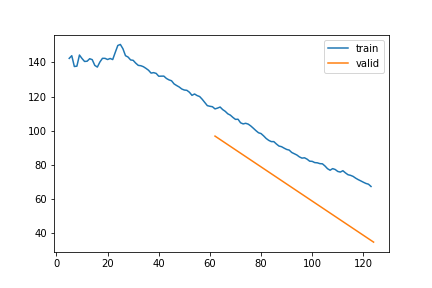

In [ ]:
spec_learn2 = {}
for var in tqdm(['TA', 'SW_IN', 'WS', 'PA', 'VPD', 'TS', 'SWC']):
    display(HTML(f"<h4> {var} | Gap len 12-336 </h4> | Training 2"))
    spec_learn2[var], _ = train_or_load(spec_learn[var].model.copy(), spec_dls[var], 2, 1e-3, base / f"{var}_specialized_gap_12-336_v2.pickle")
    plt.show()
    

`PA` and `VPD` are overfitting so repeat training 2 with only one batch

  0%|          | 0/2 [00:00<?, ?it/s]

,epoch,train_loss,valid_loss,rmse_gap,time
0,0,-135.310833,-106.027287,0.120461,24:33


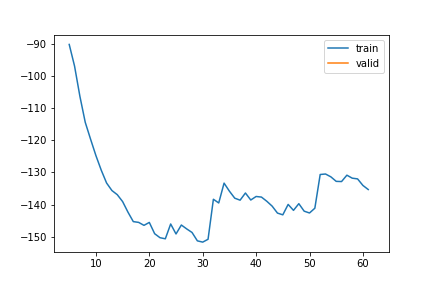

,epoch,train_loss,valid_loss,rmse_gap,time
0,0,41.435748,32.315761,0.254877,24:13


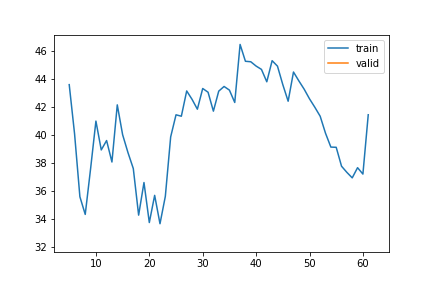

In [ ]:
spec_learn3 = {}
for var in tqdm(['PA', 'VPD']):
    display(HTML(f"<h4> {var} | Gap len 12-336 | Training 3 </h4>"))
    spec_learn3[var], _ = train_or_load(spec_learn[var].model.copy(), spec_dls[var], 1, 1e-3, base / f"{var}_specialized_gap_12-336_v3.pickle")
    plt.show()
    

  0%|          | 0/1 [00:00<?, ?it/s]

,epoch,train_loss,valid_loss,rmse_gap,time
0,0,16.858002,-7.042792,0.189336,23:31


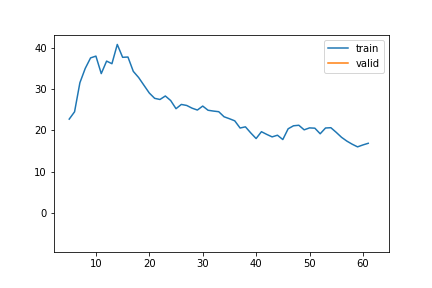

In [ ]:
spec_learn3 = {}
for var in tqdm(['TS']):
    display(HTML(f"<h4> {var} | Gap len 12-336 | Training 1+2+3 </h4>"))
    spec_learn3[var], _ = train_or_load(spec_learn2[var].model.copy(), spec_dls[var], 1, 1e-5, base / f"{var}_specialized_gap_12-336_v3")
    plt.show()
    

  0%|          | 0/1 [00:00<?, ?it/s]

,epoch,train_loss,valid_loss,rmse_gap,time
0,0,3.990423,-0.629562,0.185285,24:57


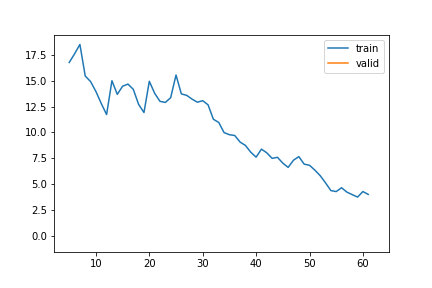

In [ ]:
for var in tqdm(['SWC']):
    display(HTML(f"<h4> {var} | Gap len 12-336 | Training 1+2+3 </h4>"))
    spec_learn3[var], _ = train_or_load(spec_learn2[var].model.copy(), spec_dls[var], 1, 1e-5, base / f"{var}_specialized_gap_12-336_v3")
    plt.show()
    

  0%|          | 0/1 [00:00<?, ?it/s]

,epoch,train_loss,valid_loss,rmse_gap,time
0,0,-1.621724,-38.955631,0.146205,23:45
1,1,-35.639923,-57.006918,0.130909,22:09


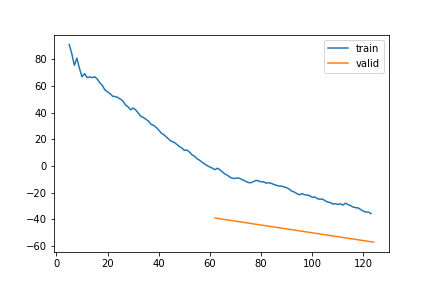

In [ ]:
for var in tqdm(['SWC']):
    display(HTML(f"<h4> {var} | Gap len 12-336 | Training 1+2+3 </h4>"))
    spec_learn3[var], _ = train_or_load(spec_learn2[var].model.copy(), spec_dls[var], 2, 1e-3, base / f"{var}_specialized_gap_12-336_v3_2")
    plt.show()
    

the training loss is getting worse ... so tring with smaller learning rate

  0%|          | 0/1 [00:00<?, ?it/s]

,epoch,train_loss,valid_loss,rmse_gap,time
0,0,-75.585425,-79.693433,0.113264,25:09


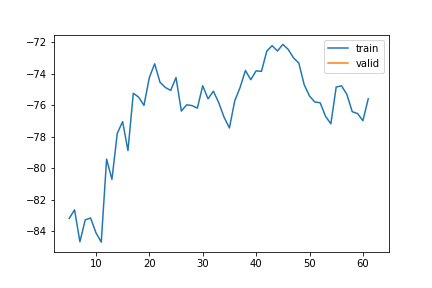

In [ ]:
for var in tqdm(['SWC']):
    display(HTML(f"<h4> {var} | Gap len 12-336 | Training 1+2+3 </h4>"))
    spec_learn3[var], _ = train_or_load(spec_learn3[var].model.copy(), spec_dls[var], 1, 1e-5, base / f"{var}_specialized_gap_12-336_v3_3")
    plt.show()
    

  0%|          | 0/1 [00:00<?, ?it/s]

epoch,train_loss,valid_loss,rmse_gap,time
0,-79.656960,-81.566511,0.113204,25:25


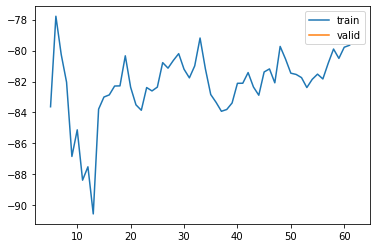

In [ ]:
for var in tqdm(['SWC']):
    display(HTML(f"<h4> {var} | Gap len 12-336 | Training 1+2+3+4 </h4>"))
    spec_learn3[var], _ = train_or_load(spec_learn3[var].model.copy(), spec_dls[var], 1, 1e-5, base / f"{var}_specialized_gap_12-336_v3_4")
    plt.show()
    

  0%|          | 0/1 [00:00<?, ?it/s]

,epoch,train_loss,valid_loss,rmse_gap,time
0,0,-0.957575,-7.084297,0.173571,24:35


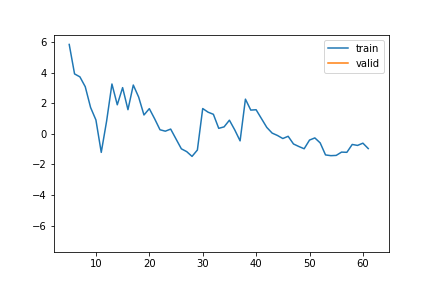

In [ ]:
spec_learn4 = {}
for var in tqdm(['SWC']):
    display(HTML(f"<h4> {var} | Gap len 12-336 | Training 1+2+3+4 </h4>"))
    spec_learn3[var], _ = train_or_load(spec_learn3[var].model.copy(), spec_dls[var], 1, 1e-5, base / f"{var}_specialized_gap_12-336_v4")
    plt.show()
    

  0%|          | 0/1 [00:00<?, ?it/s]

,epoch,train_loss,valid_loss,rmse_gap,time
0,0,158.930217,224.42966,0.701698,24:04


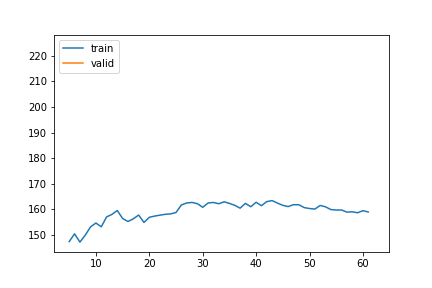

In [ ]:
for var in tqdm(['WS']):
    display(HTML(f"<h4> {var} | Gap len 12-336 | Training 1+2+3 </h4>"))
    spec_learn3[var], _ = train_or_load(spec_learn2[var].model.copy(), spec_dls[var], 1, 1e-5, base / f"{var}_specialized_gap_12-336_v3")
    plt.show()
    

this is overfitting `PA`

  0%|          | 0/1 [00:00<?, ?it/s]

,epoch,train_loss,valid_loss,rmse_gap,time
0,0,-168.729458,-122.183789,0.10763,23:40


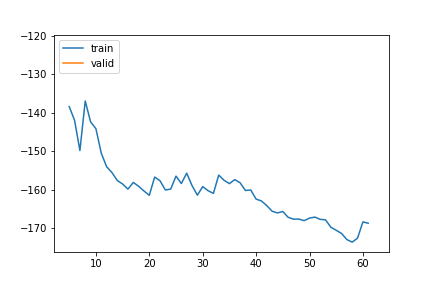

In [ ]:
for var in tqdm(['PA']):
    display(HTML(f"<h4> {var} | Gap len 12-336 | Training 1++3 </h4>"))
    spec_learn3[var], _ = train_or_load(spec_learn[var].model.copy(), spec_dls[var], 1, 1e-4, base / f"{var}_specialized_gap_12-336_v3")
    plt.show()
    

  0%|          | 0/1 [00:00<?, ?it/s]

,epoch,train_loss,valid_loss,rmse_gap,time
0,0,-169.911168,-117.59576,0.109397,21:33


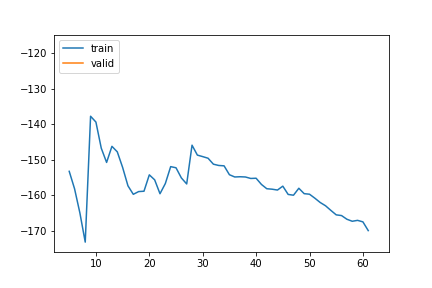

In [ ]:
spec_learn4 = {}
for var in tqdm(['PA']):
    display(HTML(f"<h4> {var} | Gap len 12-336 | Training 1+3+4 </h4>"))
    spec_learn3[var], _ = train_or_load(spec_learn3[var].model.copy(), spec_dls[var], 1, 1e-4, base / f"{var}_specialized_gap_12-336_v4")
    plt.show()
    

### Finetune gap length

In [ ]:
gap_models = {}
gap_dls = {}
gap_learn = {}
gap_items = {}
for gap_len in tqdm([6,24,48,7*48]):
    print(f"Gap len: {gap_len}")
    gap_dls[gap_len] = imp_dataloader(hai, hai_era, var_sel = gen_var_sel(list(hai.columns), n_var=1), block_len=gap_len+100, gap_len=gap_len, bs=20, control_lags=[1], n_rep=1, shifts=gen_shifts(50)).cpu()
    gap_models[gap_len] = learn_A1v.model.copy()
    display(metric_valid(learn_A1v, dls=gap_dls[gap_len].valid))
    gap_learn[gap_len], gap_items[gap_len] = train_or_load(gap_models[gap_len], gap_dls[gap_len], 3, 2e-5, base / f"gap_1_any_var_gap_len_{gap_len}_v1.pickle")
    plt.show()
    

### Fine tune TA for diff gap lens

as an experiment TA for a gap of 24 fine tuned

In [ ]:
dls_TA24 = imp_dataloader(
    df = hai,
    control = hai_era,
    var_sel = 'TA',
    block_len=100+24,
    gap_len=24,
    bs=20,
    control_lags=[1],
    shifts=gen_shifts(50),
    n_rep=1).cpu()

In [ ]:
model_TA24 = learn_A1v.model.copy()

In [ ]:
metric_valid(learn_A1v, dls= dls_TA24.valid)

  0%|          | 0/19 [00:00<?, ?it/s]

,loss,rmse
mean,-2.338763,0.184055
std,2.551372,0.034550


,epoch,train_loss,valid_loss,rmse_gap,time
0,0,-2.51402,-3.892453,0.174431,02:41


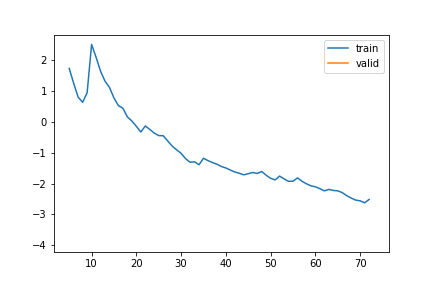

In [ ]:
learn_TA24, items_TA24 = train_or_load(model_TA24, dls_TA24, 1, 1e-4, base / "TA_gap_24_v1")

,epoch,train_loss,valid_loss,rmse_gap,time
0,0,-4.713286,-5.854372,0.161322,02:37


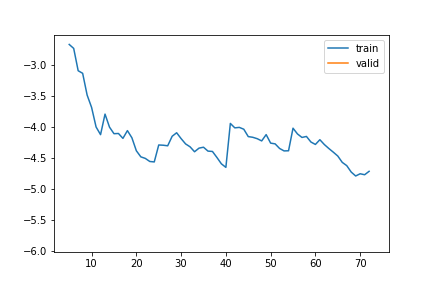

In [ ]:
learn_TA24, items_TA24 = train_or_load(model_TA24, dls_TA24, 1, 1e-4, base / "TA_gap_24_v1_2")

,epoch,train_loss,valid_loss,rmse_gap,time
0,0,-6.744339,-7.335044,0.152876,02:39


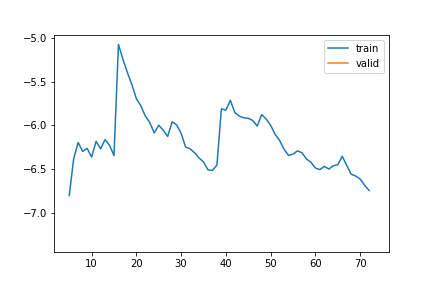

In [ ]:
learn_TA24, items_TA24 = train_or_load(model_TA24, dls_TA24, 1, 1e-4, base / "TA_gap_24_v1_3")

,epoch,train_loss,valid_loss,rmse_gap,time
0,0,-7.932901,-8.451432,0.144813,02:42


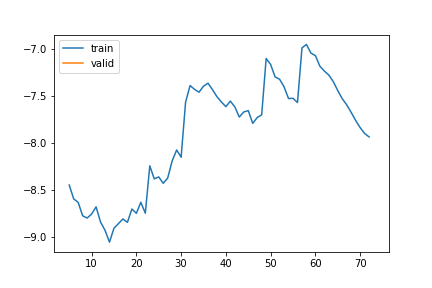

In [ ]:
learn_TA24, items_TA24 = train_or_load(model_TA24, dls_TA24, 1, 5e-5, base / "TA_gap_24_v1_4")

,epoch,train_loss,valid_loss,rmse_gap,time
0,0,-7.932901,-8.451432,0.144813,02:42


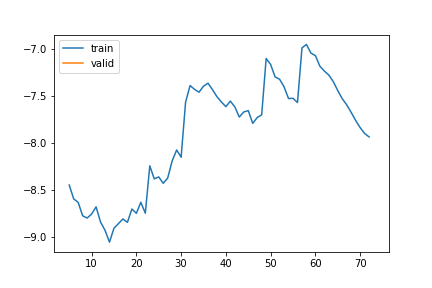

In [ ]:
learn_TA24, items_TA24 = train_or_load(model_TA24, dls_TA24, 3, 3e-5, base / "TA_gap_24_v1_4")

In [ ]:
metric_valid(learn_TA24, dls= dls_TA24.valid)

  0%|          | 0/19 [00:00<?, ?it/s]

,loss,rmse
mean,-9.049459,0.140859
std,2.104846,0.023429


In [ ]:
dls_TA48 = imp_dataloader(
    df = hai,
    control = hai_era,
    var_sel = 'TA',
    block_len=100+48,
    gap_len=48,
    bs=20,
    control_lags=[1],
    shifts=gen_shifts(50),
    n_rep=1).cpu()

In [ ]:
model_TA48 = learn_TA24.model.copy()

In [ ]:
metric_valid(learn_TA24, dls= dls_TA48.valid)

  0%|          | 0/16 [00:00<?, ?it/s]

,loss,rmse
mean,-11.247340,0.170793
std,8.504741,0.035950


,epoch,train_loss,valid_loss,rmse_gap,time
0,0,-11.938200,-13.136611,0.119232,02:38
1,1,-13.676607,-14.978353,0.111058,02:38


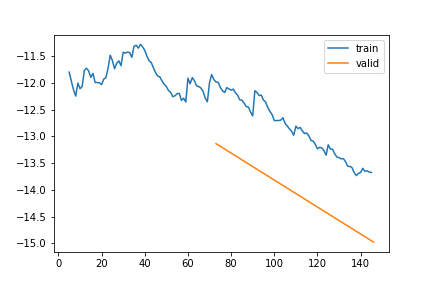

In [ ]:
learn_TA48, items_TA48 = train_or_load(model_TA24, dls_TA24, 2, 2e-4, base / "TA_gap_48_v1")

,epoch,train_loss,valid_loss,rmse_gap,time
0,0,-15.563658,-15.840925,0.107003,02:44
1,1,-15.958545,-16.626610,0.103149,02:54


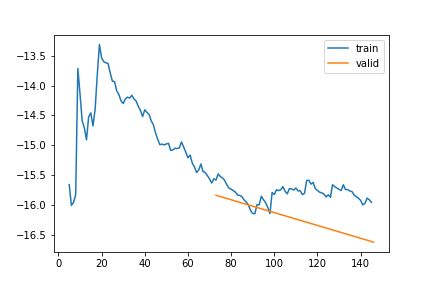

In [ ]:
learn_TA48, items_TA48 = train_or_load(model_TA24, dls_TA24, 2, 1e-4, base / "TA_gap_48_v1_2")

,epoch,train_loss,valid_loss,rmse_gap,time
0,0,-16.665217,-17.394887,0.099992,02:40
1,1,-17.165897,-17.974066,0.097933,02:43


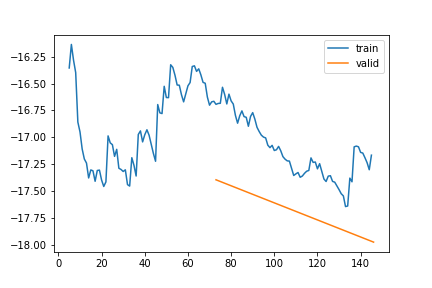

In [ ]:
learn_TA48, items_TA48 = train_or_load(model_TA24, dls_TA24, 2, 1e-4, base / "TA_gap_48_v1_3")

,epoch,train_loss,valid_loss,rmse_gap,time
0,0,-18.111798,-18.427618,0.096457,02:49
1,1,-18.591682,-19.413278,0.092474,02:52


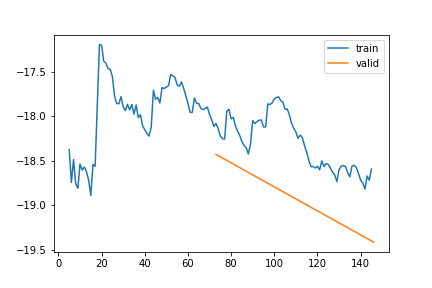

In [ ]:
learn_TA48, items_TA48 = train_or_load(model_TA24, dls_TA24, 2, 1e-4, base / "TA_gap_48_v1_4")

In [ ]:
model_TA24_v2 = KalmanFilterSR.init_local_slope_pca(
    n_dim_obs= len(hai.columns),
    n_dim_state=len(hai.columns),
    n_dim_contr = len(hai_era.columns),
    df_pca = hai, 
    pred_only_gap=True)

In [ ]:
learn_TA24_v2, items_TA24_v2 = train_or_load(model_TA24, dls_TA24, 3, 1e-3, base / "TA_gap_24_v2_1")

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

,loss,rmse
mean,-2.093156,0.102643
std,0.403933,0.025537


epoch,train_loss,valid_loss,rmse_gap,time
0,-3.623101,-4.139968,0.074969,03:57
1,-5.193550,-5.537112,0.060948,04:14
2,-6.309246,-6.533323,0.052087,04:33
3,-7.058736,-7.211129,0.046813,04:22


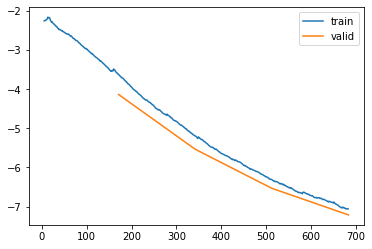

  0%|          | 0/37 [00:00<?, ?it/s]

,loss,rmse
mean,-0.660455,0.200111
std,2.088128,0.031036


epoch,train_loss,valid_loss,rmse_gap,time
0,-4.815664,-5.862635,0.162549,05:23
1,-8.257145,-9.265403,0.141516,05:27
2,-10.721531,-11.764655,0.126987,05:17
3,-13.121913,-13.537241,0.119559,05:31


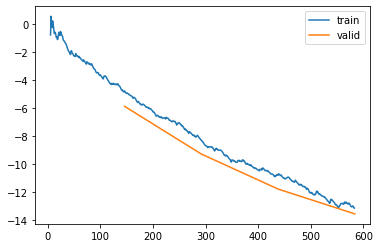

  0%|          | 0/31 [00:00<?, ?it/s]

,loss,rmse
mean,2.231489,0.227216
std,4.624743,0.032391


epoch,train_loss,valid_loss,rmse_gap,time
0,-5.077721,-6.730453,0.189337,06:57
1,-10.696784,-12.647214,0.166578,06:37
2,-15.724886,-16.361526,0.153221,06:56
3,-18.714646,-19.920346,0.142614,06:41


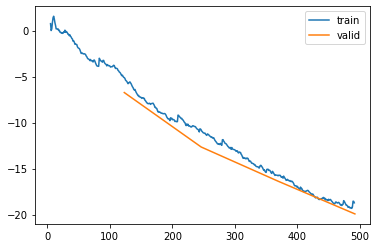

  0%|          | 0/11 [00:00<?, ?it/s]

,loss,rmse
mean,30.665105,0.248255
std,18.911530,0.021534


epoch,train_loss,valid_loss,rmse_gap,time
0,18.701340,-1.243045,0.226205,17:41
1,-0.477330,-23.318493,0.212453,17:30
2,-19.797870,-42.075069,0.200830,47:23
3,-36.470670,-55.291288,0.192844,18:24


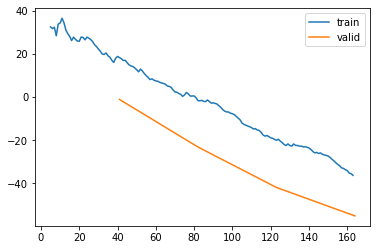

In [ ]:
TA_models = {}
TA_dls = {}
TA_learn = {}
TA_items = {}
for gap_len in tqdm([6,24,48,7*48]):
    display(HTML(f"<h4> TA | Gap len: {gap_len} </h4>"))
    TA_dls[gap_len] = imp_dataloader(hai, hai_era, var_sel = 'TA', block_len=gap_len+100, gap_len=gap_len, bs=20, control_lags=[1], n_rep=2, shifts=gen_shifts(50)).cpu()
    TA_models[gap_len] = learn_A1v.model.copy()
    display(metric_valid(learn_A1v, dls=TA_dls[gap_len].valid))
    TA_learn[gap_len], TA_items[gap_len] = train_or_load(TA_models[gap_len], TA_dls[gap_len], 4, 1e-4, base / f"TA_gap_len_{gap_len}_v1.pickle")
    plt.show()
    

### TA multiple gap len 

In [ ]:
dls_TA = imp_dataloader(
    df = hai,
    control = hai_era,
    var_sel = 'TA',
    block_len=70+336,
    gap_len=gen_gap_len(12,336),
    bs=20,
    control_lags=[1],
    shifts=gen_shifts(50),
    n_rep=3).cpu()

In [ ]:
model_TA = learn_A1v.model.copy()

In [ ]:
metric_valid(learn_A1v, dls= dls_TA.valid)

  0%|          | 0/17 [00:00<?, ?it/s]

,loss,rmse
mean,18.120834,0.240742
std,19.321141,0.032218


,epoch,train_loss,valid_loss,rmse_gap,time
0,0,-26.097331,-37.440739,0.175528,25:36
1,1,-50.443927,-66.472712,0.149401,26:02


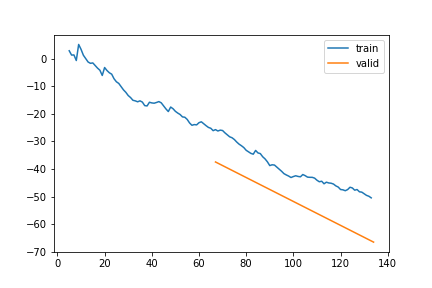

In [ ]:
learn_TA, items_TA = train_or_load(model_TA, dls_TA, 2, 5e-4, base / "TA_gap_12-336_v1,")

epoch,train_loss,valid_loss,rmse_gap,time
0,-70.902275,-72.341130,0.137253,24:20
1,-78.379055,-76.962878,0.132967,23:55


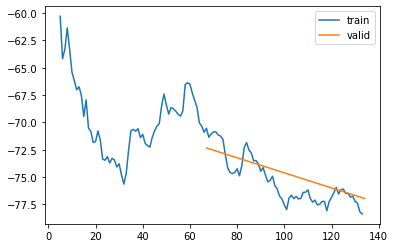

In [ ]:
learn_TA, items_TA = train_or_load(learn_TA.model, dls_TA, 2, 5e-4, base / "TA_gap_12-336_v2")

epoch,train_loss,valid_loss,rmse_gap,time
0,-85.106441,-82.588917,0.128094,24:21
1,-86.267741,-83.305525,0.129777,23:29


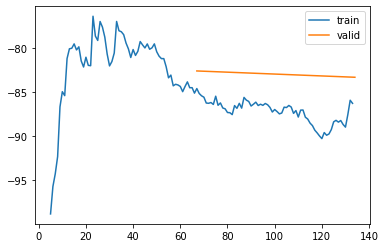

In [ ]:
learn_TA, items_TA = train_or_load(learn_TA.model, dls_TA, 2, 5e-4, base / "TA_gap_12-336_v3")

### Detailed metrics

In [ ]:
def metrics_valid_gap_lens(learn, var, gaps = [6,12,24,48,7*48]):
    for gap_len in tqdm(gaps):
        dls = imp_dataloader(hai, hai_era, var_sel = var, block_len=gap_len+100, gap_len=gap_len, bs=20, control_lags=[1], n_rep=1, shifts=gen_shifts(50)).cpu()
        display(HTML(f"<strong> Metrics | gap len: {gap_len} | Var: {var} </strong>"))
        display(metric_valid(learn, dls=dls.valid))

/home/simone/anaconda3/envs/data-science/lib/python3.10/site-packages/fastai/callback/core.py:69: UserWarning: You are shadowing an attribute (__class__) that exists in the learner. Use `self.learn.__class__` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


In [ ]:
metrics_valid_gap_lens(learn_A1v, 'TA')

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

,loss,rmse
mean,-2.649933,0.095968
std,0.338268,0.018444


  0%|          | 0/21 [00:00<?, ?it/s]

,loss,rmse
mean,-3.243049,0.134065
std,0.710149,0.021311


  0%|          | 0/19 [00:00<?, ?it/s]

,loss,rmse
mean,-2.125709,0.188222
std,2.047966,0.027886


  0%|          | 0/16 [00:00<?, ?it/s]

,loss,rmse
mean,0.638268,0.217725
std,6.192707,0.031585


  0%|          | 0/6 [00:00<?, ?it/s]

,loss,rmse
mean,21.469734,0.242877
std,9.829365,0.010609


In [ ]:
metrics_valid_gap_lens(learn_A1v_nc, 'TA')

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

,loss,rmse
mean,-3.430541,0.055689
std,0.097171,0.009796


  0%|          | 0/21 [00:00<?, ?it/s]

,loss,rmse
mean,-3.790838,0.113533
std,0.833381,0.030206


  0%|          | 0/19 [00:00<?, ?it/s]

,loss,rmse
mean,-0.992221,0.187918
std,4.834171,0.068321


  0%|          | 0/16 [00:00<?, ?it/s]

,loss,rmse
mean,5.597832,0.235436
std,12.132120,0.075510


  0%|          | 0/6 [00:00<?, ?it/s]

,loss,rmse
mean,96.691128,0.293088
std,98.837141,0.085536


In [ ]:
metrics_valid_gap_lens(spec_learn['TA'], 'TA')

/home/simone/anaconda3/envs/data-science/lib/python3.10/site-packages/fastai/callback/core.py:69: UserWarning: You are shadowing an attribute (__class__) that exists in the learner. Use `self.learn.__class__` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

,loss,rmse
mean,-6.332682,0.049233
std,0.226535,0.007010


  0%|          | 0/21 [00:00<?, ?it/s]

,loss,rmse
mean,-10.478126,0.072882
std,0.762210,0.010581


  0%|          | 0/19 [00:00<?, ?it/s]

,loss,rmse
mean,-15.977039,0.103628
std,4.186457,0.024085


  0%|          | 0/16 [00:00<?, ?it/s]

,loss,rmse
mean,-25.748188,0.125292
std,11.229092,0.031731


  0%|          | 0/6 [00:00<?, ?it/s]

,loss,rmse
mean,-136.930894,0.152361
std,61.110281,0.026692


In [ ]:
metrics_valid_gap_lens(spec_learn["SWC"], 'SWC', gaps=[6,12,24,30])

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

,loss,rmse
mean,-4.637960,0.051318
std,0.299619,0.012608


  0%|          | 0/21 [00:00<?, ?it/s]

,loss,rmse
mean,-6.503471,0.078820
std,0.751687,0.020815


  0%|          | 0/19 [00:00<?, ?it/s]

,loss,rmse
mean,-6.256985,0.114699
std,1.533914,0.030592


  0%|          | 0/18 [00:00<?, ?it/s]

,loss,rmse
mean,-3.957636,0.144434
std,2.228843,0.032844


In [ ]:
metrics_valid_gap_lens(spec_learn3["SWC"], 'SWC', gaps=[6,12,24,30])

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

,loss,rmse
mean,-7.409364,0.040791
std,0.602997,0.008078


  0%|          | 0/21 [00:00<?, ?it/s]

,loss,rmse
mean,-14.166100,0.049997
std,1.298232,0.009736


  0%|          | 0/19 [00:00<?, ?it/s]

,loss,rmse
mean,-26.025482,0.058914
std,2.035570,0.009232


  0%|          | 0/18 [00:00<?, ?it/s]

,loss,rmse
mean,-31.526816,0.064446
std,2.601954,0.008842


In [ ]:
metrics_valid_gap_lens(learn_Aa, 'SWC', gaps=[6,12,24,30])

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

,loss,rmse
mean,-10.621700,0.020779
std,1.637564,0.009605


  0%|          | 0/21 [00:00<?, ?it/s]

,loss,rmse
mean,-21.012826,0.024119
std,1.456359,0.007166


  0%|          | 0/19 [00:00<?, ?it/s]

,loss,rmse
mean,-36.451721,0.034461
std,4.163576,0.011231


  0%|          | 0/18 [00:00<?, ?it/s]

,loss,rmse
mean,-43.786023,0.038519
std,5.267340,0.010467


this is pretty weird the model with gaps in all variables is performing better that the one with only partial gaps ....

let's so some finetuning 

### SWC | Gap len 30 

In [ ]:
dls_SWC_30 = imp_dataloader(
    df = hai,
    control = hai_era,
    var_sel = 'SWC',
    block_len=120,
    gap_len=30,
    bs=20,
    control_lags=[1],
    shifts=gen_shifts(50),
    n_rep=1
).cpu()

In [ ]:
model_SWC_30 = spec_learn['SWC'].copy()

In [ ]:
if show_metrics: metric_valid(model_SWC_30, dls=model_SWC_30.valid)

epoch,train_loss,valid_loss,rmse_gap,time
0,-10.998339,-15.672505,0.099315,02:51
1,-17.301334,-22.166437,0.085715,02:51


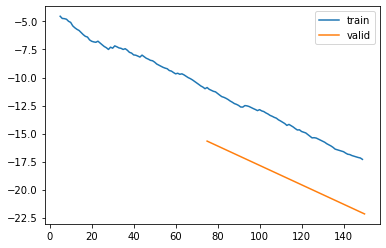

In [ ]:
learn_SWC_30, items_SWC_30 = train_or_load(model_SWC_30, dls_SWC_30, 2, 3e-4, base / "SWC_gap_30_v1")

epoch,train_loss,valid_loss,rmse_gap,time
0,-27.642977,-34.401863,0.056773,02:56
1,-33.920003,-38.631508,0.050980,02:57


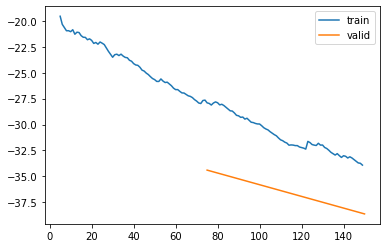

In [ ]:
learn_SWC_30, items_SWC_30 = train_or_load(model_SWC_30, dls_SWC_30, 2, 1e-3, base / "SWC_gap_30_v2")

epoch,train_loss,valid_loss,rmse_gap,time
0,-38.766184,-42.612718,0.041158,02:55
1,-39.593180,-42.984206,0.041554,02:52


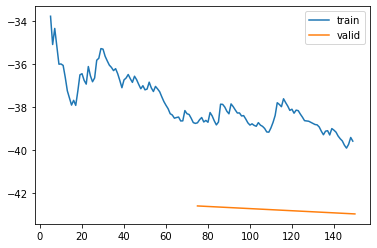

In [ ]:
learn_SWC_30, items_SWC_30 = train_or_load(model_SWC_30, dls_SWC_30, 2, 1e-3, base / "SWC_gap_30_v3")

epoch,train_loss,valid_loss,rmse_gap,time
0,-38.766184,-42.612718,0.041158,02:55
1,-39.593180,-42.984206,0.041554,02:52


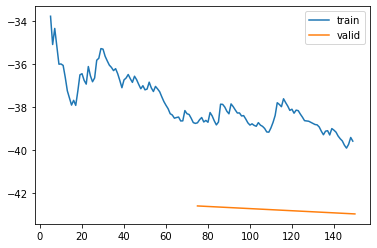

In [ ]:
learn_SWC_30, items_SWC_30 = train_or_load(model_SWC_30, dls_SWC_30, 2, 1e-3, base / "SWC_gap_30_v3")

In [ ]:
show_results(learn_SWC_30, hide_no_gap=True, items=items_SWC_30)

[MeteoImpItem(i=1674, shift=30, var_sel=['SWC'], gap_len=30), MeteoImpItem(i=1693, shift=46, var_sel=['SWC'], gap_len=30), MeteoImpItem(i=1570, shift=-83, var_sel=['SWC'], gap_len=30), MeteoImpItem(i=1682, shift=54, var_sel=['SWC'], gap_len=30)]


alt.HConcatChart(...)

In [ ]:
show_results(learn_Aa, hide_no_gap=True, items=items_SWC_30)

[MeteoImpItem(i=1674, shift=30, var_sel=['SWC'], gap_len=30), MeteoImpItem(i=1693, shift=46, var_sel=['SWC'], gap_len=30), MeteoImpItem(i=1570, shift=-83, var_sel=['SWC'], gap_len=30), MeteoImpItem(i=1682, shift=54, var_sel=['SWC'], gap_len=30)]


alt.HConcatChart(...)

In [ ]:
show_results(learn_A1v, hide_no_gap=True, items=items_SWC_30, dls=dls_SWC_30)

[MeteoImpItem(i=1674, shift=30, var_sel=['SWC'], gap_len=30), MeteoImpItem(i=1693, shift=46, var_sel=['SWC'], gap_len=30), MeteoImpItem(i=1570, shift=-83, var_sel=['SWC'], gap_len=30), MeteoImpItem(i=1682, shift=54, var_sel=['SWC'], gap_len=30)]


alt.HConcatChart(...)

In [ ]:
show_results(spec_learn['SWC'], hide_no_gap=True, items=spec_items['SWC'], dls=spec_dls['SWC'])

[MeteoImpItem(i=510, shift=10, var_sel=['SWC'], gap_len=243), MeteoImpItem(i=504, shift=0, var_sel=['SWC'], gap_len=109), MeteoImpItem(i=494, shift=-94, var_sel=['SWC'], gap_len=116), MeteoImpItem(i=481, shift=-17, var_sel=['SWC'], gap_len=148)]


alt.HConcatChart(...)

In [ ]:
show_results(learn_SWC_30)

[MeteoImpItem(i=1892, shift=-50, var_sel=['SWC'], gap_len=30), MeteoImpItem(i=1667, shift=68, var_sel=['SWC'], gap_len=30), MeteoImpItem(i=1761, shift=41, var_sel=['SWC'], gap_len=30)]
